In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
from automatic_speech_recognition.utils.graph_utils import fixate_rnn_shape
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
import pickle
import seaborn as sns
sns.set()

os.environ['PATH'] += ':/gpfs/gpfs0/r.schutski/'

# Testing utilities

In [14]:
from glob import glob
import json
from tflite_device_profile import (check_device, run_on_device, parse_profiler_output, batch_profile)
from tflite_device_profile import DEFAULT_PROF_CONFIG as config
from h5_to_tflite import (export_model, batch_export)

In [15]:
os.environ['ANDROID_ADB_SERVER_PORT'] = '5043'  # select which ADB to use. 5037 - local, 5038 - remote

check_device(True, adb_cmd='adb-1.0.39')

# Turn off phone's gpu usage, it can't handle anything
config['use_gpu'] = False
config['num_threads'] = 1
config['enable_op_profiling'] = False
config['num_runs'] = 5000
cpu_affinity = [4]

Found device: AEJ0117C11000167


# Test original deepspeech

In [16]:
deepspeech = asr.model.load_mozilla_deepspeech('./data/myfrozen.pb', verbose=False)
fixate_rnn_shape(deepspeech, 2).save(f'./models/mozilla_deepspeech3_tfliteready.h5')
export_model(f'./models/mozilla_deepspeech_tfliteready.h5', f'./tflite_models/mozilla_deepspeech.tflite', run_tests=True)

load graph


converting: ./models/mozilla_deepspeech_tfliteready.h5 => ./tflite_models/mozilla_deepspeech.tflite


In [17]:
# profile reference model
ref_res = run_on_device('./tflite_models/mozilla_deepspeech.tflite', 
                        prof_config=config, 
                        cpu_affinity=cpu_affinity)
ref_result = parse_profiler_output(ref_res, is_file=False)
ref_result

ref_time = float(ref_result['main']['avg'])
ref_std = float(ref_result['main']['std'])

print(f"Reference time {ref_time} +- {ref_std}")

Reference time 284506.0 +- 18633.0


In [18]:
print(ref_res)

STARTING!
Min num runs: [5000]
Min runs duration (seconds): [1]
Max runs duration (seconds): [300]
Inter-run delay (seconds): [-1]
Num threads: [1]
Benchmark name: []
Output prefix: []
Min warmup runs: [30]
Min warmup runs duration (seconds): [0.5]
Graph: [/sdcard/asr_profiling/mozilla_deepspeech.tflite]
Input layers: []
Input shapes: []
Use nnapi : [0]
nnapi execution preference: [sustained_speed]
Use legacy nnapi : [0]
Use gpu : [0]
Allow lower precision in gpu : [0]
Preferred GL object type in gpu : [0]
Allow fp16 : [0]
Require full delegation : [0]
Enable op profiling: [0]
Max profiling buffer entries: [1024]
Loaded model /sdcard/asr_profiling/mozilla_deepspeech.tflite
resolved reporter
`--use_nnapi=true` must be set for the provided NNAPI execution preference (sustained_speed) to be used.
Initialized session in 2.006ms
Running benchmark for at least 30 iterations and at least 0.5 seconds but terminate if exceeding 300 seconds.
count=30 first=297379 curr=250855 min=176835 max=29737

# Convert maxvol models to tflite

In [7]:
for filename in os.listdir('./models'):
    if 'maxvolled' in filename and 'tfliteready' not in filename and filename.startswith('lstm_desnse234'):
        name = filename.split('.')[0]
        # skip if already converted
        if os.path.exists(f'./tflite_models/{name}.tflite'):
            continue
        # fixate shape
        print(f"Start fixating {name}")
        fixate_rnn_shape(keras.models.load_model(f'./models/{name}.h5'), 2).save(f'./models/{name}_tfliteready.h5')
        # export dense model
        export_model(f'./models/{name}_tfliteready.h5', f'./tflite_models/{name}.tflite', run_tests=True)

In [8]:
test_results = {}
for filename in os.listdir('./tflite_models'):
    if 'maxvolled' in filename and filename.startswith('lstm_desnse234'):
        name = filename.split('.')[0]
        print(f"Profiling {name}")
        # profile model
        res = run_on_device(f'./tflite_models/{name}.tflite', 
                                prof_config=config, 
                                cpu_affinity=cpu_affinity)
        result = parse_profiler_output(res, is_file=False)
        time = float(result['main']['avg'])
        std = float(result['main']['std'])

        print(f"Time for {name} is {time} +- {std}")
        test_results[name] = (time, std)
with open('./maxvol_stats/speeduptest.pickle', 'wb+') as f:
    pickle.dump(test_results, f)

Profiling lstm_desnse234_2vol_maxvolled_deepspeech_r500
Time for lstm_desnse234_2vol_maxvolled_deepspeech_r500 is 47218.7 +- 583.0
Profiling lstm_desnse234_1vol_maxvolled_deepspeech_r1000
Time for lstm_desnse234_1vol_maxvolled_deepspeech_r1000 is 58439.4 +- 929.0
Profiling lstm_desnse234_2vol_maxvolled_deepspeech_r1400
Time for lstm_desnse234_2vol_maxvolled_deepspeech_r1400 is 133005.0 +- 1665.0
Profiling lstm_desnse234_2vol_maxvolled_deepspeech_r1000
Time for lstm_desnse234_2vol_maxvolled_deepspeech_r1000 is 94566.0 +- 1351.0
Profiling lstm_desnse234_1vol_maxvolled_deepspeech_r300
Time for lstm_desnse234_1vol_maxvolled_deepspeech_r300 is 19086.5 +- 264.0
Profiling lstm_desnse234_2vol_maxvolled_deepspeech_r1200
Time for lstm_desnse234_2vol_maxvolled_deepspeech_r1200 is 114976.0 +- 1206.0
Profiling lstm_desnse234_1vol_maxvolled_deepspeech_r1500
Time for lstm_desnse234_1vol_maxvolled_deepspeech_r1500 is 107468.0 +- 1668.0
Profiling lstm_desnse234_2vol_maxvolled_deepspeech_r1500
Time for 

In [9]:
with open('./maxvol_stats/speeduptest.pickle', 'rb') as f:
    test_results = pickle.load(f)

In [10]:
def get_run_rank(name):
    return int(name[name.index('_r') + 2:])

def get_run_name(name):
    return name[:name.index('_2vol_maxvolled')]

def is_full_change(name, maxvol_type=''):
    assert maxvol_type in ('', '1vol', '2vol')
    return name.startswith('lstm_desnse234_' + maxvol_type)

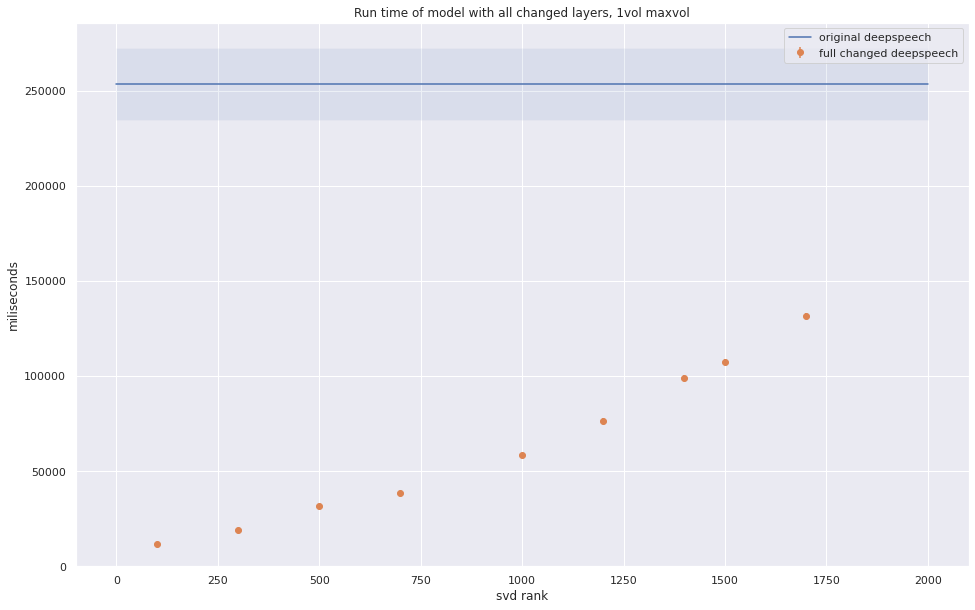

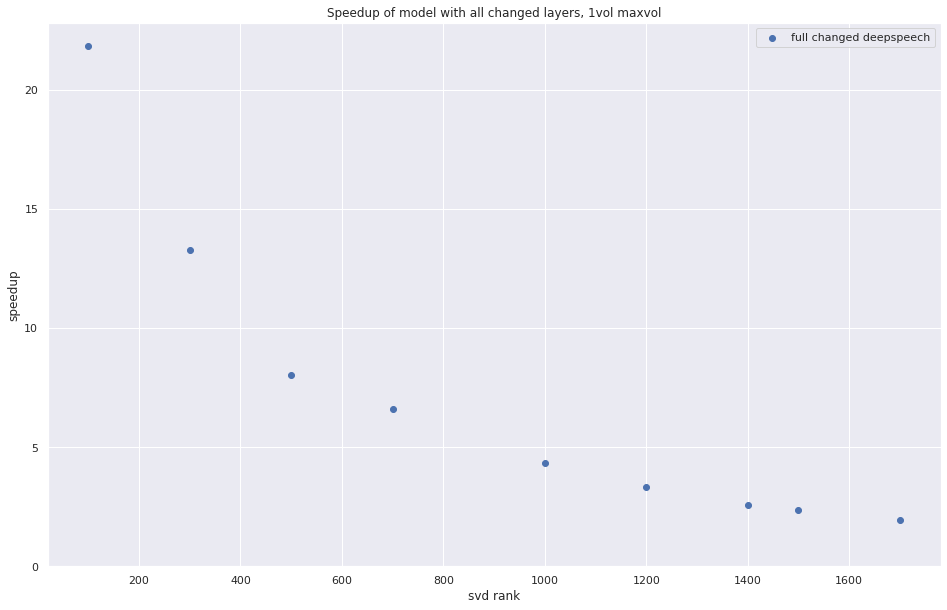

In [11]:
full_change_ranks = []
full_change_avg = []
full_change_std = []
for result_name, result_data in test_results.items():
    if is_full_change(result_name, '1vol'):
        full_change_ranks.append(get_run_rank(result_name))
        full_change_avg.append(result_data[0])
        full_change_std.append(result_data[1])
        
full_change_avg = np.array(full_change_avg)
full_change_std = np.array(full_change_std)

plt.figure(figsize=(16, 10))
plt.title('Run time of model with all changed layers, 1vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('miliseconds')
plt.plot([0, 2000], [ref_time, ref_time], label='original deepspeech')
plt.fill_between([0, 2000], [ref_time - ref_std, ref_time - ref_std], [ref_time + ref_std, ref_time + ref_std], alpha=0.1)
plt.errorbar(full_change_ranks, full_change_avg, yerr=full_change_std, fmt='o',label='full changed deepspeech')
# plt.fill_between([0, 2000], full_change_avg + full_change_std, full_change_avg - full_change_std)
plt.ylim([0, None])
plt.legend()
plt.show()

plt.figure(figsize=(16, 10))
plt.title('Speedup of model with all changed layers, 1vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('speedup')
plt.scatter(full_change_ranks, ref_time / full_change_avg, label='full changed deepspeech')
plt.ylim([0, None])
plt.legend()

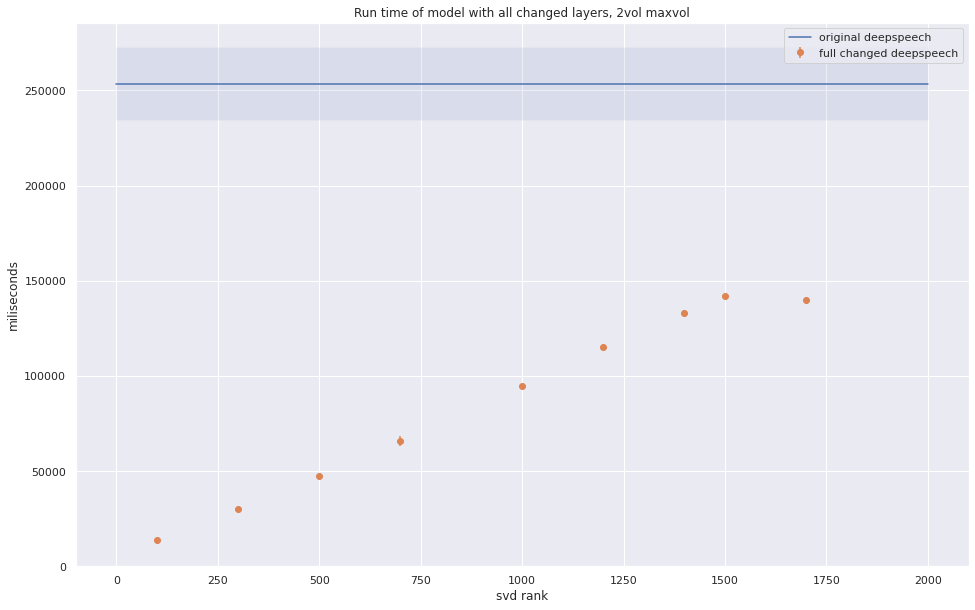

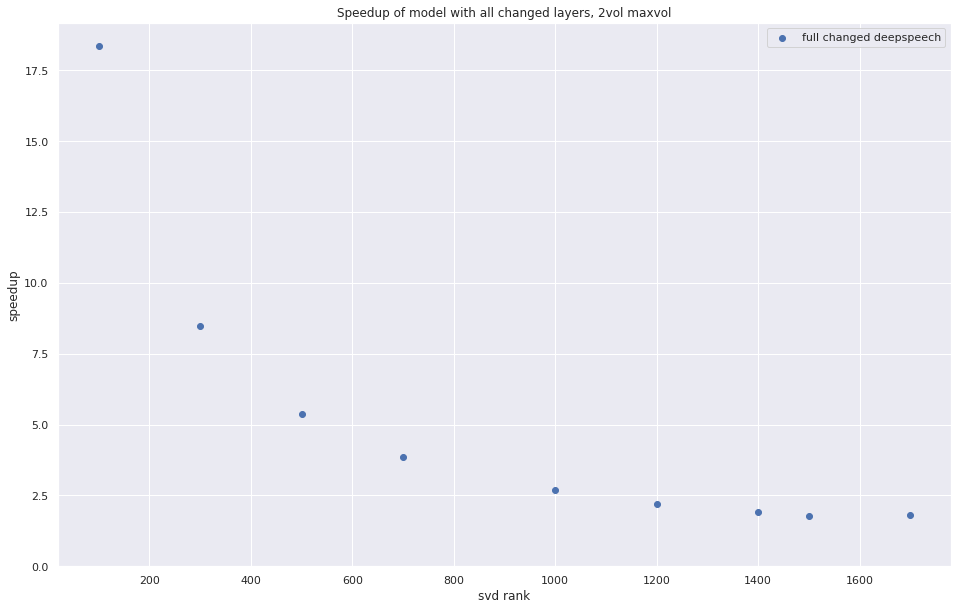

In [12]:
full_change_ranks = []
full_change_avg = []
full_change_std = []
for result_name, result_data in test_results.items():
    if is_full_change(result_name, '2vol'):
        full_change_ranks.append(get_run_rank(result_name))
        full_change_avg.append(result_data[0])
        full_change_std.append(result_data[1])
        
full_change_avg = np.array(full_change_avg)
full_change_std = np.array(full_change_std)

plt.figure(figsize=(16, 10))
plt.title('Run time of model with all changed layers, 2vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('miliseconds')
plt.plot([0, 2000], [ref_time, ref_time], label='original deepspeech')
plt.fill_between([0, 2000], [ref_time - ref_std, ref_time - ref_std], [ref_time + ref_std, ref_time + ref_std], alpha=0.1)
plt.errorbar(full_change_ranks, full_change_avg, yerr=full_change_std, fmt='o',label='full changed deepspeech')
# plt.fill_between([0, 2000], full_change_avg + full_change_std, full_change_avg - full_change_std)
plt.ylim([0, None])
plt.legend()

plt.figure(figsize=(16, 10))
plt.title('Speedup of model with all changed layers, 2vol maxvol')
plt.xlabel('svd rank')
plt.ylabel('speedup')
plt.scatter(full_change_ranks, ref_time / full_change_avg, label='full changed deepspeech')
plt.ylim([0, None])
plt.legend()